<h1 align='center'><font color='navy'>Udacity Machine Learning Engineer - Nanodegree</font></h1>
<h2 align='center'><font color='teal'>Capstone Project</font></h2>
<h3 align='center'><font color='maroon'>Amrishkumar Purohit</font></h3>                                                            

<h2><font color='olive'>Introduction</font></h2>

Estimating price of a house is quite challenging and important process as housing prices are difficult to predict, and can be influenced by a very large quantity of factors. Everyone want better home in lease amount.

Now days there are many real estate companies provide data and own define algorithm to determine best price of the house. One of such company is Zillow. Zillow has millions of data on homes across United States. 

Goal of the project is to predict price of new property going to sold in Los Angeles, Orange and Ventura county of California. Here price of home is evaluated based on features of home

<h2><font color='olive'>Table of Content</font></h2>

<h3><font color='purple'> [1.](#1) Packages and Data set</font></h3>
<h3><font color='purple'> [2.](#2) Exploratory Analysis of Data (EAD)</font></h3>

* [Step 1](#step1): Data Exploration
* [Step 2](#step2): Preprocessing
* [Step 3](#step3): Construct and Evaluate Benchmark Model
* [Step 4](#step4): Feature Selection and Model Evaluation
* [Step 5](#step5): Model Tuning
* [Step 6](#step6): Final Model Training and Prediction
* [Step 7](#step7): Conclusion

---
<a id='1'></a>
<h2><font color='olive'> [1.](#1) Packages and Data set</font></h2>

Code in this notebook is compiled with Python 3.
Here is list of packages used in this project.
- numpy 
- pandas
- bokeh
- gc
- catboost
- xgboost
- sklearn

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import row, column
import gc
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
# Set bokeh graphs to load in Jupyter Notebook
output_notebook()

# Load the properties_2016 dataset. Low_memory=False needed due to size of the dataset.
#properties = pd.read_csv('data/properties_2017.csv', low_memory=False)

# Load the training dataset which contain the label to train on, logerror.
#training = pd.read_csv('data/train_2017.csv', parse_dates=['transactiondate'])

# Success
#print ("Zillow 2017 properties dataset has {} data points with {} features.".format(*properties.shape))
#print ("Zillow 2017 training dataset has {} data points with {} features.".format(*training.shape))

Loading BokehJS ...

<a id='2'></a>
<h2><font color='olive'> [2.](#2) Exploratory Analysis of Data (EAD)</font></h2>





In [43]:
#Reading Training Data
train = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])
print ("Shape Of Training Data: ",train.shape)
train.head()

Shape Of Training Data:  (77613, 3)


,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


In [44]:
#Reading Properties Data
prop = pd.read_csv("data/properties_2017.csv", low_memory=False)
print ("Shape Of Properties Data: ",prop.shape)
prop.head()

Shape Of Properties Data:  (2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [45]:
#Merging training and properties filed on unique field 'parcelid'
train = pd.merge(train, prop, on='parcelid', how='left')
print ("Shape Of Merged Training Data: ",train.shape)
train.head()

Shape Of Merged Training Data:  (77613, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,14297519,0.025595,2017-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13
1,17052889,0.055619,2017-01-01,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13
2,14186244,0.005383,2017-01-01,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13
3,12177905,-0.103410,2017-01-01,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13
4,10887214,0.006940,2017-01-01,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13


In [46]:
#Dropping Columns who's %age of NaN values is greater than 70%
for col in list(train.columns.values):
    nanValues = float(train[col].isnull().sum()) / len(train)
    if nanValues > 0.70:
        print("Dropping column {}".format(col))
        train = train.drop([col], axis=1)
print("Shape of Training Data : {}".format(train.shape))

Dropping column architecturalstyletypeid
Dropping column basementsqft
Dropping column buildingclasstypeid
Dropping column decktypeid
Dropping column finishedfloor1squarefeet
Dropping column finishedsquarefeet13
Dropping column finishedsquarefeet15
Dropping column finishedsquarefeet50
Dropping column finishedsquarefeet6
Dropping column fireplacecnt
Dropping column hashottuborspa
Dropping column poolcnt
Dropping column poolsizesum
Dropping column pooltypeid10
Dropping column pooltypeid2
Dropping column pooltypeid7
Dropping column storytypeid
Dropping column threequarterbathnbr
Dropping column typeconstructiontypeid
Dropping column yardbuildingsqft17
Dropping column yardbuildingsqft26
Dropping column numberofstories
Dropping column fireplaceflag
Dropping column taxdelinquencyflag
Dropping column taxdelinquencyyear
Shape of Training Data : (77613, 35)


### Correlation Analysis

                           Count     Column Type
0                       parcelid           int64
1                       logerror         float64
2                transactiondate  datetime64[ns]
3          airconditioningtypeid         float64
4                    bathroomcnt         float64
5                     bedroomcnt         float64
6          buildingqualitytypeid         float64
7              calculatedbathnbr         float64
8   calculatedfinishedsquarefeet         float64
9           finishedsquarefeet12         float64
10                          fips         float64
11                   fullbathcnt         float64
12                  garagecarcnt         float64
13               garagetotalsqft         float64
14         heatingorsystemtypeid         float64
15                      latitude         float64
16                     longitude         float64
17             lotsizesquarefeet         float64
18     propertycountylandusecode          object
19         propertyl

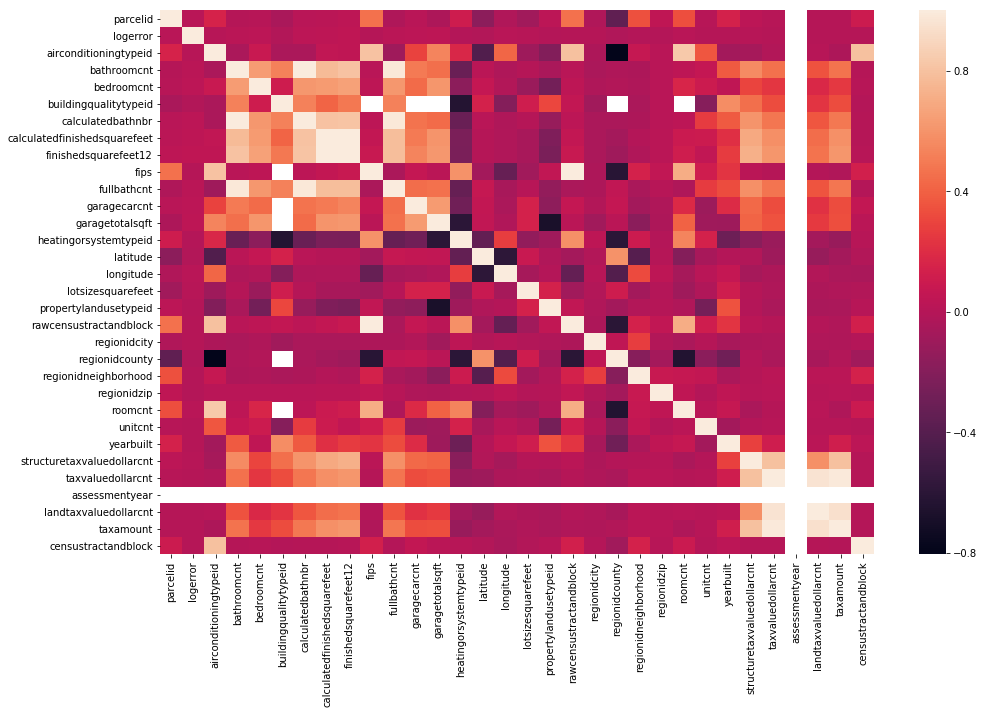

In [47]:
#Printing out all the Variables
data_type = train.dtypes.reset_index()
data_type.columns = ["Count", "Column Type"]
print(data_type)

# Correlation Matrix
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(), fmt="d")

In [4]:
# Use pandas merge function to join the training data and the properties on the unique identifier 'parcelid'
data = training.merge(properties, how='left', on='parcelid')

# Drop columns that are redundant. See cell above this one for details.
data = data.drop(['basementsqft', 'bathroomcnt','threequarterbathnbr', 'finishedfloor1squarefeet',
                 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', 
                 'finishedsquarefeet15', 'finishedsquarefeet50', 'fireplaceflag', 'fullbathcnt',
                 'pooltypeid7', 'rawcensustractandblock', 'censustractandblock'], axis=1)

---
<a id='step1'></a>
## Step 1: Data Exploration

In [3]:
# Set larger display properties so that the entire data set can be scrolled
pd.options.display.max_columns = 500

# Take a quick look at the training dataframe
data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
0,11016594,0.0276,2016-01-01,1.0,NaN,3.0,NaN,4.0,2.0,NaN,1684.0,6037.0,NaN,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,0100,261.0,LARS,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN
1,14366692,-0.1684,2016-01-01,NaN,NaN,4.0,NaN,NaN,3.5,NaN,2263.0,6059.0,NaN,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,1,261.0,NaN,32380.0,1286.0,NaN,96962.0,0.0,NaN,NaN,NaN,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,2.0,NaN,4.0,3.0,NaN,2217.0,6037.0,NaN,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,0100,261.0,PSR6,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN
3,12643413,0.0218,2016-01-02,1.0,NaN,2.0,NaN,4.0,2.0,NaN,839.0,6037.0,NaN,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,010C,266.0,LAR3,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN
4,14432541,-0.0050,2016-01-02,NaN,NaN,4.0,NaN,NaN,2.5,NaN,2283.0,6059.0,NaN,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,122,261.0,NaN,17686.0,1286.0,NaN,96961.0,8.0,NaN,NaN,NaN,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN


In [4]:
# Get summary statistics for the training set
data.describe(include='all')

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
count,9.027500e+04,90275.000000,90275,28781.000000,261.000000,90275.000000,16.0,57364.000000,89093.000000,658.0,89614.000000,90275.000000,9607.000000,29937.000000,29937.000000,2365,56080.000000,9.027500e+04,9.027500e+04,8.012500e+04,17901.0,969.000000,1161.0,1204.0,90274,90275.000000,58313,88472.000000,90275.000000,36012.000000,90240.000000,90275.000000,43.0,299.000000,58353.000000,2646.000000,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783,1783.000000
unique,NaN,NaN,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,NaN,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
top,NaN,NaN,2016-07-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0100,NaN,LAR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN
freq,NaN,NaN,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30846,NaN,7678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1783,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.298466e+07,0.011457,NaN,1.816372,7.229885,3.031869,4.0,5.565407,2.309216,66.0,1773.185987,6048.870551,1.187884,1.812005,345.521228,NaN,3.926979,3.400541e+07,-1.181989e+08,2.911016e+04,1.0,519.827657,1.0,1.0,NaN,261.832179,NaN,33761.332851,2525.420770,190646.540237,96586.131184,1.478516,7.0,6.010033,1.110414,310.142101,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,NaN,13.402692
std,2.504510e+06,0.161079,NaN,2.974168,2.716196,1.156436,0.0,1.900602,0.976172,0.0,928.162393,20.663461,0.484173,0.608761,267.015918,NaN,3.684382,2.649654e+05,3.606032e+05,1.217213e+05,0.0,155.054210,0.0,0.0,NaN,5.182901,NaN,46672.393863,805.694842,166228.910572,3661.339094,2.819627,0.0,0.437235,0.797235,216.721869,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,NaN,2.715966
min,1.071174e+07,-4.605000,NaN,1.000000,2.000000,0.000000,4.0,1.000000,1.000000,66.0,2.000000,6037.000000,1.000000,0.000000,0.000000,NaN,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,1.0,28.000000,1.0,1.0,NaN,31.000000,NaN,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,4.000000,1.000000,25.000000,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,NaN,6.000000
25%,1.155950e+07,-0.025300,NaN,1.000000,7.000000,2.000000,4.0,4.000000,2.000000,66.0,1184.000000,6037.000000,1.000000,2.000000,0.000000,NaN,2.000000,3.381154e+07,-1.184117e+08,5.703000e+03,1.0,420.000000,1.0,1.0,NaN,261.000000,NaN,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,6.000000,1.000000,180.000000,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,NaN,13.000000


The parcelid is the unique identifier for this dataset, it's summary statistics can be ignored. Transaction dates span the enire year, according to the competition description, there should be a reduced number of data points for the last three months of 2016. The majority of those datapoints are in the leaderboard testing set.

The count of most of the columns is far below the sample size of 90,275. There is a lot of missing information.

Looking at the min and the max of the log error compared to the std, it is pretty clear that the dataset features some outliers.  The mean log error is quite small, but the min indicates that there are negative values, plotting the distribution of the log error will help reveal whether this is an issue or not.

In [5]:
hist, edges = np.histogram(data['logerror'], bins=500)

p = figure(title="Histogram of log error", plot_width=400, plot_height=300,)

p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="red")

p.x_range.start = -0.4
p.x_range.end = 0.4
p.y_range.start = 0
p.title.align='center'

show(p)

The log error is normally distributed around 0, which is consistent with the provided information about the Zestimate algorithim's current level of accuracy. Since the mean is averaging together values that are distributed fairly evenly on both sides of zero and with similar magnitudes, I'll take the absolute value of the log error column and then rerun the summary stats.


In [6]:
# Get summary statistics for the absolute value of log error
data['abs_logerror'] = data['logerror'].abs()
data['abs_logerror'].describe()

count    90275.000000
mean         0.068447
std          0.146262
min          0.000000
25%          0.013900
50%          0.032500
75%          0.069400
max          4.737000
Name: abs_logerror, dtype: float64

This mean is more indicitive of how far away from a perfect score the zestimate is on average. This still backs up the claim that Zestimates are pretty accurate currently, especially considering the outliers. If they were removed, the average would decrease even further.

I'm interested in digging into the outliers a little deeper. Since this dataset is representing actual Zestimates, I'll move under the assumption that the log error outliers are not a result of improperly entered data. They have to then represent the houses where the Zestimate was performing at its worst.

In [7]:
outliers = data.copy()
outliers = outliers.loc[data['abs_logerror'] >= 0.4] # Rough estimate
outliers.describe(include='all')

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,abs_logerror
count,1.844000e+03,1844.000000,1844,410.000000,2.0,1844.000000,4.0,1322.000000,1752.000000,11.0,1796.000000,1844.000000,125.00000,364.000000,364.000000,34,1138.000000,1.844000e+03,1.844000e+03,1.709000e+03,309.0,9.000000,16.0,18.0,1844,1844.000000,1396,1814.000000,1844.000000,854.000000,1841.000000,1844.000000,2.0,3.0,1384.000000,36.000000,4.000000,1790.000000,334.000000,1.819000e+03,1.844000e+03,1844.0,1.844000e+03,1844.000000,95,95.000000,1844.000000
unique,NaN,NaN,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46,NaN,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
top,NaN,NaN,2016-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0100,NaN,LAR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
freq,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,791,NaN,196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95,NaN,NaN
first,NaN,NaN,2016-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.261991e+07,0.216184,NaN,1.575610,7.0,2.963124,4.0,6.095310,2.281963,66.0,1868.792316,6045.636659,1.25600,1.909341,416.829670,NaN,4.724956,3.402337e+07,-1.182452e+08,2.849766e+04,1.0,614.222222,1.0,1.0,NaN,259.704989,NaN,32935.448181,2712.591649,193531.781030,96611.215644,1.053688,7.0,6.0,1.257225,313.500000,281.250000,1955.860335,1.353293,1.942313e+05,5.341758e+05,2015.0,3.425778e+05,7211.245315,NaN,13.863158,0.801167
std,1.601172e+06,0.949725,NaN,2.536846,0.0,1.508071,0.0,1.860785,1.300883,0.0,1259.057428,19.022341,0.63378,1.590267,518.947699,NaN,3.902158,2.522127e+05,3.295977e+05,1.093441e+05,0.0,127.965599,0.0,0.0,NaN,11.781367,NaN,51321.783302,709.080933,161697.653449,7079.863201,2.401583,0.0,0.0,0.692083,210.012177,232.073803,25.905870,0.554294,3.834565e+05,1.036399e+06,0.0,7.223003e+05,12528.850764,NaN,9.043171,0.553645
min,1.071561e+07,-4.605000,NaN,1.000000,7.0,0.000000,4.0,1.000000,1.000000,66.0,40.000000,6037.000000,1.00000,0.000000,0.000000,NaN,2.000000,3.334135e+07,-1.194470e+08,6.300000e+02,1.0,462.000000,1.0,1.0,NaN,31.000000,NaN,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,6.0,1.000000,72.000000,144.000000,1890.000000,1.000000,1.000000e+02,1.044000e+03,2015.0,9.400000e+02,64.000000,NaN,8.000000,0.400100
25%,1.158348e+07,-0.499200,NaN,1.000000,7.0,2.000000,4.0,4.000000,1.000000,66.0,1100.000000,6037.000000,1.00000,1.000000,184.500000,NaN,2.000000,3.388973e+07,-1.184003e+08,5.512000e+03,1.0,525.000000,1.0,1.0,NaN,261.000000,NaN,12447.000000,3101.000000,47950.000000,96102.000000,0.000000,7.0,6.0,1.000000,203.000000,148.500000,1938.000000,1.000000,5.442950e+04,1.297168e+05,2015.0,5.282925e+04,2255.847500,NaN,12.000000,0.474700


In [8]:
non_outliers = data.copy()
non_outliers = non_outliers.loc[data['abs_logerror'] < 0.4]
non_outliers.describe(include='all')

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,abs_logerror
count,8.843100e+04,88431.000000,88431,28371.000000,259.000000,88431.000000,12.0,56042.000000,87341.000000,647.0,87818.000000,88431.000000,9482.000000,29573.000000,29573.000000,2331,54942.000000,8.843100e+04,8.843100e+04,7.841600e+04,17592.0,960.000000,1145.0,1186.0,88430,88431.000000,56917,86658.000000,88431.000000,35158.000000,88399.000000,88431.000000,41.0,296.000000,56969.000000,2610.000000,91.000000,87729.000000,20236.000000,8.807600e+04,8.843000e+04,88431.0,8.843000e+04,88425.000000,1688,1688.000000,88431.000000
unique,NaN,NaN,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,NaN,1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
top,NaN,NaN,2016-07-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0100,NaN,LAR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
freq,NaN,NaN,897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30055,NaN,7482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1688,NaN,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.299226e+07,0.007188,NaN,1.819851,7.231660,3.033303,4.0,5.552907,2.309763,66.0,1771.230704,6048.937986,1.186986,1.810807,344.643526,NaN,3.910451,3.400504e+07,-1.181979e+08,2.912351e+04,1.0,518.942708,1.0,1.0,NaN,261.876537,NaN,33778.620981,2521.517805,190576.456738,96585.608774,1.487374,7.0,6.010135,1.106848,310.095785,313.032967,1968.791437,1.442182,1.798014e+05,4.560773e+05,2015.0,2.769957e+05,5958.382658,NaN,13.376777,0.053168
std,2.519347e+06,0.082443,NaN,2.979913,2.726628,1.147925,0.0,1.899763,0.968548,0.0,920.060355,20.691017,0.481870,0.586506,262.308909,NaN,3.677943,2.652132e+05,3.611598e+05,1.219777e+05,0.0,155.069105,0.0,0.0,NaN,4.943025,NaN,46570.277757,807.128152,166339.056775,3555.451706,2.827019,0.0,0.439451,0.799288,216.851618,351.361683,23.647316,0.544231,2.039589e+05,5.401909e+05,0.0,3.908709e+05,6666.467656,NaN,1.795134,0.063416
min,1.071174e+07,-0.399000,NaN,1.000000,2.000000,0.000000,4.0,1.000000,1.000000,66.0,2.000000,6037.000000,1.000000,0.000000,0.000000,NaN,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,1.0,28.000000,1.0,1.0,NaN,31.000000,NaN,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,4.000000,1.000000,25.000000,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,NaN,6.000000,0.000000
25%,1.155875e+07,-0.025300,NaN,1.000000,7.000000,2.000000,4.0,4.000000,2.000000,66.0,1186.000000,6037.000000,1.000000,2.000000,0.000000,NaN,2.000000,3.381050e+07,-1.184120e+08,5.707750e+03,1.0,420.000000,1.0,1.0,NaN,261.000000,NaN,12447.000000,1286.000000,46736.000000,96197.000000,0.000000,7.0,6.000000,1.000000,180.000000,98.000000,1953.000000,1.000000,8.196500e+04,2.006512e+05,2015.0,8.300000e+04,2890.140000,NaN,13.000000

1,844 of the 90,275 homes are listed as ouliers according to my rough estimate. The outlier value should be around 0.5 and above, but hindsight showed better performing models with a 0.4 cutoff.

Digging through the cells above, the outliers as a whole are slightly larger homes. They have higher average assessed value and taxes to pay. This may indicate that the Zillow algorithim has trouble with bigger, more expensive homes.

That point can't be proven conclusively though, because the imbalance between sample sizes is far too great. For instance, despite the outliers having larger average square footage, comparing max values of some of the stats above show that the largest, most expensive property is in the normal sample.

There's something about the outliers that is throwing off the Zestimate. I'd like to be able to say that it's just a function of the size and value of the properties, and it might be, but it also might not even be represented in the data provided by Zillow. Real estate markets fluctuate for many reasons, most of which are probably not present in this data. This data describes the properties themselves, not the real estate market.

Since the training data includes the date of sale, I'll next take a look at this information in the context of sales period.

In [9]:
# Create a new column for the month during which the transaction occured
outliers['transaction_month'] = outliers['transactiondate'].dt.month
non_outliers['transaction_month'] = non_outliers['transactiondate'].dt.month
data['transaction_month'] = data['transactiondate'].dt.month

# Use newly created column to create a dataframe grouped by transaction month
outliers_grouped = outliers.groupby('transaction_month')
non_outliers_grouped = non_outliers.groupby('transaction_month')
grouped = data.groupby('transaction_month')

# Create a new dataframe that applies the mean function to the absolute value of the log error of each group's members
outliers_grouped_abs_month = outliers_grouped['abs_logerror'].aggregate(np.mean)
non_outliers_grouped_abs_month = non_outliers_grouped['abs_logerror'].aggregate(np.mean)
grouped_abs_month = grouped['abs_logerror'].aggregate(np.mean)

In [10]:
# Create a vertical bar graph of the number of houses sold per month for outliers
p1 = figure(plot_width=400, plot_height=300, x_axis_label="Month",
            y_axis_label="Number of Houses Sold", title="Sales per Month - Outliers")

p1.vbar(x=outliers['transaction_month'].value_counts().index,
        top=outliers['transaction_month'].value_counts().values,
        width=0.5, bottom=0, color="red")

p1.y_range.start = 0
p1.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12]
p1.title.align='center'

# Create a vertical bar graph of the number of houses sold per month for non-outliers
p2 = figure(plot_width=400, plot_height=300, x_axis_label="Month",
             y_axis_label="Number of Houses Sold", title="Sales per Month - Non_Outliers")
            
p2.vbar(x=non_outliers['transaction_month'].value_counts().index,
        top=non_outliers['transaction_month'].value_counts().values,
        width=0.5, bottom=0, color="green")
            
p2.y_range.start = 0
p2.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12]
p2.title.align='center'

# Create a line graph of average abs log error by transaction month for outliers
p3 = figure(plot_width=400, plot_height=300, x_axis_label="Month",
            y_axis_label="Mean absolute log error",
            title="Mean Abs Log Error per Month - Outliers")

p3.line(x=outliers_grouped_abs_month.index,
        y=outliers_grouped_abs_month.values,
        line_width=2, color="red")

p3.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12]
p3.title.align='center'

# Create a line graph of average abs log error by transaction month for non-outliers
p4 = figure(plot_width=400, plot_height=300, x_axis_label="Month",
            y_axis_label="Mean absolute log error",
            title="Mean Abs Log Error per Month - Non-Outliers")

p4.line(x=non_outliers_grouped_abs_month.index,
        y=non_outliers_grouped_abs_month.values,
        line_width=2, color="green")

p4.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12]
p4.title.align='center'

show(column(row(p1, p2), row(p3,p4)))

### Please note the difference in the vertical scale between the outlier and non-outlier sets of graphs

It's hard to draw conclussions with only a semi-complete year worth of sales data, but I'll try anyway.

Both outliers and non-outliers follow similar trends:
- Fewer homes are sold in winter and fall months.
- Log error is highest for both outliers and non-outliers for those periods.
- As sales volume increases, log error decreases

Looking at the difference in scale, the outliers have approximately 13 to 20 times the average log error for any given month. Once again, those numbers can be decieving due to the massive difference in sample size, but the general trend that these graphs reveal should prove useful: colder months are tougher for the Zestimate algorithim.

In [11]:
# Create a vertical bar graph of the number of houses sold per month for all samples
p5 = figure(plot_width=800, plot_height=300, x_axis_label="Month",
            y_axis_label="Number of Houses Sold", title="Sales per Month 2016 - All Samples")

p5.vbar(x=data['transaction_month'].value_counts().index,
        top=data['transaction_month'].value_counts().values,
        width=0.5, bottom=0, color="blue")

p5.y_range.start = 0
p5.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12]
p5.title.align='center'

# Create a line graph of average abs log error by transaction month for all samples
p6 = figure(plot_width=800, plot_height=300, x_axis_label="Month",
            y_axis_label="Mean absolute log error",
            title="Mean Abs Log Error per Month 2016 - All Samples")

p6.line(x=grouped_abs_month.index,
        y=grouped_abs_month.values,
        line_width=2, color="blue")

p6.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12]
p6.title.align='center'
show(column(p5, p6))

In [12]:
#number of non-NAN values per column
data.count()

parcelid                        90275
logerror                        90275
transactiondate                 90275
airconditioningtypeid           28781
architecturalstyletypeid          261
bedroomcnt                      90275
buildingclasstypeid                16
buildingqualitytypeid           57364
calculatedbathnbr               89093
decktypeid                        658
calculatedfinishedsquarefeet    89614
fips                            90275
fireplacecnt                     9607
garagecarcnt                    29937
garagetotalsqft                 29937
hashottuborspa                   2365
heatingorsystemtypeid           56080
latitude                        90275
longitude                       90275
lotsizesquarefeet               80125
poolcnt                         17901
poolsizesum                       969
pooltypeid10                     1161
pooltypeid2                      1204
propertycountylandusecode       90274
propertylandusetypeid           90275
propertyzoni

---
<a id='step2'></a>
## Step 2: Preprocessing

In [13]:
#Since the dataframes can consume a large amount of RAM, run a reset to free up memory
%reset -f

In [14]:
#reload data
import numpy as np
import pandas as pd
import gc

properties = pd.read_csv('data/properties_2016.csv', low_memory=False)
training = pd.read_csv('data/train_2016_v2.csv', parse_dates=['transactiondate'])
data = training.merge(properties, how='left', on='parcelid')

# Drop columns that are redundant
data = data.drop(['basementsqft', 'bathroomcnt','threequarterbathnbr', 'finishedfloor1squarefeet',
                 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', 
                 'finishedsquarefeet15', 'finishedsquarefeet50', 'fireplaceflag', 'fullbathcnt',
                 'pooltypeid7', 'rawcensustractandblock', 'censustractandblock'], axis=1)

# Create a new column for the transaction month from the original transactiondate column
data['transaction_month'] = data['transactiondate'].dt.month

del training
gc.collect()

28

In [15]:
# If ~50% of the column's data is NAN, drop the column.
for column in data.columns:
    x = data[column].count()
    if x < 45000:
        data = data.drop(column, axis=1)

In [16]:
# drop columns containing mixed text and numerical data
data = data.drop([ 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

In [17]:
# Check for correlation between log error and remaining features
corr = data.corr()
print(corr["logerror"][2:].sort_values(ascending=False))

calculatedfinishedsquarefeet    0.038784
calculatedbathnbr               0.029448
bedroomcnt                      0.025467
structuretaxvaluedollarcnt      0.022085
yearbuilt                       0.017312
fips                            0.008363
taxvaluedollarcnt               0.006508
transaction_month               0.006421
roomcnt                         0.005760
latitude                        0.004915
lotsizesquarefeet               0.004835
propertylandusetypeid           0.001003
regionidcounty                  0.000341
regionidcity                   -0.002121
landtaxvaluedollarcnt          -0.003051
longitude                      -0.003432
unitcnt                        -0.003983
regionidzip                    -0.006507
taxamount                      -0.006671
buildingqualitytypeid          -0.009573
heatingorsystemtypeid          -0.025018
assessmentyear                       NaN
Name: logerror, dtype: float64


In [18]:
# Compress the log error of outliers
for idx in data.index:
    q = data.get_value(idx, 'logerror')
    if q > 0.4:
        x = q / 2
        data.set_value(idx, 'logerror', x)
    elif q < -0.4:
        x = q / 2
        data.set_value(idx, 'logerror', x) 
    
# Create training label
label = data["logerror"]
data = data.drop(['logerror', 'parcelid', 'transactiondate'], 1)

In [19]:
'''
I ended up having multiple warnings when running an imputer and scaler on the standard splits created
by this module, so I created my own train, test splits in the cell below.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=10)'''

'\nI ended up having multiple warnings when running an imputer and scaler on the standard splits created\nby this module, so I created my own train, test splits in the cell below.\n\nfrom sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=10)'

In [20]:
X_train = data[:70000].copy()
y_train = label[:70000].copy()
X_test = data[70000:].copy()
y_test = label[70000:].copy()

In [21]:
numerical = ['calculatedbathnbr', "bedroomcnt", "calculatedfinishedsquarefeet", "latitude",
            "longitude", "lotsizesquarefeet", "yearbuilt", "structuretaxvaluedollarcnt",
            "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount", 'unitcnt']

categorical = ["buildingqualitytypeid", "heatingorsystemtypeid", "regionidzip", "regionidcity", "transaction_month"]


In [22]:
from sklearn.preprocessing import Imputer, StandardScaler

imputer = Imputer(missing_values='NaN', strategy='median', axis=0)

imputer = imputer.fit(X_train[numerical])
X_train[numerical] = imputer.transform(X_train[numerical])
X_test[numerical] = imputer.transform(X_test[numerical])

In [23]:
scaler = StandardScaler()
      
scaler = scaler.fit(X_train[numerical])    
X_train[numerical] = scaler.transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

In [24]:
cat_imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

cat_imputer = cat_imputer.fit(X_train[categorical])
X_train[categorical] = cat_imputer.transform(X_train[categorical])
X_test[categorical] = cat_imputer.transform(X_test[categorical])

---
<a id='step3'></a>
## Step 3: Construct and Evaluate Benchmark

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

scorer = make_scorer(mean_absolute_error)

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=4)
result = cross_val_score(tree, X_train, y_train, cv=5, scoring=scorer)
print("CV MAE - Decision Tree: {}".format(result))
print("Mean CV MAE - Decision Tree: {}".format(result.mean()))

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
test_result = mean_absolute_error(y_test, y_pred)

print("Test MAE - Decision Tree: {}".format(test_result))

CV MAE - Decision Tree: [ 0.06439136  0.0617895   0.05996048  0.0581979   0.05773291]
Mean CV MAE - Decision Tree: 0.06041442976629606
Test MAE - Decision Tree: 0.058831142144009446


The benchmark model actually turns in a relatively good performance. This is a competition where top scores are separated by a few thousandths though, so every little increase counts.

---
<a id='step4'></a>
## Step 4: Feature Selection and Model Evaluation

In [27]:
# Build a forest and compute the feature importances
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500,
                            random_state=0,
                            n_jobs=-1)

rfr.fit(X_train, y_train)
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]

values = sorted(zip(X_train.columns, rfr.feature_importances_), key=lambda x: x[1] * -1)
y = 1
for value in values:
    if y < 16:
        print("{}. {} : {}".format(y, value[0], value[1]))
        y += 1

1. calculatedfinishedsquarefeet : 0.09780644083063292
2. structuretaxvaluedollarcnt : 0.09605802327300925
3. lotsizesquarefeet : 0.09326787572591433
4. latitude : 0.09247400871792907
5. longitude : 0.09222498630443741
6. taxamount : 0.0890158369958759
7. landtaxvaluedollarcnt : 0.07821088757646259
8. taxvaluedollarcnt : 0.07530930905072054
9. yearbuilt : 0.0682782305551786
10. regionidzip : 0.05708566032339589
11. transaction_month : 0.03961812644946378
12. regionidcity : 0.03488061889775703
13. bedroomcnt : 0.023236048764829532
14. calculatedbathnbr : 0.017703291748791605
15. propertylandusetypeid : 0.01191685154185546


The most important featues as identified by the Random Forest model. Comparing these values to the correlation print out above helps confirm that most of these features are the right choice for simplifying the training while maintaining predictive accuracy.

In [28]:
# regioncityid left off since lat, long, and zip were already covering location data fairly well. Propertylandusetypeid
# features a mix of numeric and text data, so it was dropped for simplicity.

X_train = X_train[['calculatedbathnbr', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                         'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt',
                         'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                         'landtaxvaluedollarcnt', 'taxamount', 'regionidzip',
                         'transaction_month']]

X_test = X_test[['calculatedbathnbr', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                         'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt',
                         'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                         'landtaxvaluedollarcnt', 'taxamount', 'regionidzip',
                         'transaction_month']]

In [29]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(n_jobs=-1)

result = cross_val_score(lr, X_train, y_train, cv=5, scoring=scorer)
print("CV MAE - Linear Regression:{}".format(result))
print("Mean CV MAE - Linear Regression: {}".format(result.mean()))

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
test_result = mean_absolute_error(y_test, y_pred)
print("Test MAE - Linear Regression: {}".format(test_result))

CV MAE - Linear Regression:[ 0.06413073  0.06182095  0.05987398  0.05811601  0.05738716]
Mean CV MAE - Linear Regression: 0.06026576316326213
Test MAE - Linear Regression: 0.058869530623936565


In [30]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500,
                            max_depth=4,
                            random_state=10,
                            n_jobs=-1)

result = cross_val_score(rfr, X_train, y_train, cv=5, scoring=scorer)
print("CV MAE - Random Forest:{}".format(result))
print("Mean CV MAE - Random Forest: {}".format(result.mean()))

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
test_result = mean_absolute_error(y_test, y_pred)
print("Test MAE - Random Forest: {}".format(test_result))


CV MAE - Random Forest:[ 0.06388533  0.06140331  0.05984625  0.05794013  0.05747072]
Mean CV MAE - Random Forest: 0.06010914745114648
Test MAE - Random Forest: 0.058664051121699666


In [31]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=500,
                        learning_rate=0.03,
                        depth=4, l2_leaf_reg=4,
                        loss_function='MAE',
                        eval_metric='MAE',
                        random_seed=10)

result = cross_val_score(cat, X_train, y_train, cv=5, scoring=scorer)
print("CV MAE - CatBoost:{}".format(result))
print("Mean CV MAE - CatBoost: {}".format(result.mean()))

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
test_result = mean_absolute_error(y_test, y_pred)
print("Test MAE - CatBoost: {}".format(test_result))

CV MAE - CatBoost:[ 0.06417314  0.06087166  0.05902951  0.05746267  0.0575832 ]
Mean CV MAE - CatBoost: 0.05982403535102687
Test MAE - CatBoost: 0.05853323125510442


In [32]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
params = {}
params['eta'] = 0.03
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

xg = xgb.train(params, d_train, 500)
y_pred = xg.predict(d_test)
test_result = mean_absolute_error(y_test, y_pred)
print("Test MAE - XGBoost: {}".format(test_result))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Test MAE - XGBoost: 0.05880377765461255


The CatBoost model produced the best CV and test scores. I couldn't figure out how to use the cross validation model from sklearn with the XGBoost model since XGBoost requires data in a special format, so I've only got a test score to go off of for it. Regardless, all 4 models perform very similarly, with CatBoost taking a slight lead, so that is the model I will attempt to tune.

---
<a id='step5'></a>
## Step 5: Model Tuning

In [33]:
'''from sklearn.model_selection import GridSearchCV

cat = CatBoostRegressor(loss_function='MAE',
                    eval_metric='MAE',
                    random_seed=10)

params = {'iterations': [800, 1000, 1200],
     'learning_rate': [0.015, 0.03, 0.06, 0.005],
     'depth': [3, 4, 5, 6],
     'l2_leaf_reg': [1, 5, 10, 15]}

gs = GridSearchCV(cat, params, scorer, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

y_pred = gs.predict(X_test)
test_result = mean_absolute_error(y_test, y_pred)
print("Test MAE - GridSearch CatBoost: {}".format(test_result))'''

'from sklearn.model_selection import GridSearchCV\n\ncat = CatBoostRegressor(loss_function=\'MAE\',\n                    eval_metric=\'MAE\',\n                    random_seed=10)\n\nparams = {\'iterations\': [800, 1000, 1200],\n     \'learning_rate\': [0.015, 0.03, 0.06, 0.005],\n     \'depth\': [3, 4, 5, 6],\n     \'l2_leaf_reg\': [1, 5, 10, 15]}\n\ngs = GridSearchCV(cat, params, scorer, cv=5, n_jobs=-1)\ngs.fit(X_train, y_train)\nprint(gs.best_params_)\nprint(gs.best_score_)\n\ny_pred = gs.predict(X_test)\ntest_result = mean_absolute_error(y_test, y_pred)\nprint("Test MAE - GridSearch CatBoost: {}".format(test_result))'

I discovered that tree based models have an issue using gridsearch with n_jobs set to -1. They quickly consume a huge amount of RAM. I'm running this on a laptop, so I don't have much RAM to work with. Setting n_jobs to 1 allowed the code to run without consuming all of my system RAM, but imposed time issues. I was running out of time to submit to the competition, so I couldn't make a thorough search of parameters on one cpu core. My final model was achieved by picking a few values randomly and running them one at a time to compare CV and test scores.

My focus was on CV scores though since my manually created train and test splits were not shuffled.

In [34]:
cat = CatBoostRegressor(iterations=1000,
                        learning_rate=0.005,
                        depth=4, l2_leaf_reg=15,
                        loss_function='MAE',
                        eval_metric='MAE',
                        random_seed=10)

result = cross_val_score(cat, X_train, y_train, cv=5, scoring=scorer)
print("CV MAE - CatBoost:{}".format(result))
print("Mean CV MAE - CatBoost: {}".format(result.mean()))

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
test_result = mean_absolute_error(y_test, y_pred)
print("Test MAE - CatBoost: {}".format(test_result))

CV MAE - CatBoost:[ 0.0640457   0.06089537  0.05903173  0.05744854  0.05713766]
Mean CV MAE - CatBoost: 0.05971179877295404
Test MAE - CatBoost: 0.058179423271085086


---
<a id='step6'></a>
## Step 6: Final Model Training and Prediction
#### Retrain model using the entire training dataset

In [35]:
#Since the dataframes can consume a large amount of RAM, run a reset to free up memory
%reset -f

In [36]:
import numpy as np
import pandas as pd
import gc

print("-------------------------Beginning Training-------------------------")

# Load the properties 2016 dataset. Low_memory=False needed due to size of the dataset.
properties = pd.read_csv('data/properties_2016.csv', low_memory=False)

# Load the training 2016 dataset which contains the label to train on, logerror.
training = pd.read_csv('data/train_2016_v2.csv', parse_dates=['transactiondate'])

# Use pandas merge function to join the training data and the properties on the unique identifier 'parcelid'
data = training.merge(properties, how='left', on='parcelid')

del training
gc.collect()

# Create a new column for the transaction month from the original transactiondate column
data['transaction_month'] = data['transactiondate'].dt.month

# Select the most useful features
data = data[['logerror', 'calculatedbathnbr', 'bedroomcnt', 'calculatedfinishedsquarefeet',
             'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt',
             'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
             'landtaxvaluedollarcnt', 'taxamount', 'regionidzip',
             'transaction_month']]

# Compress the log error of outliers
for idx in data.index:
    q = data.get_value(idx, 'logerror')
    if q > 0.4:
        x = q / 2
        data.set_value(idx, 'logerror', x)
    elif q < -0.4:
        x = q / 2
        data.set_value(idx, 'logerror', x)

# Create target and drop it from the training data
label = data["logerror"]
data = data.drop(['logerror'], 1)

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib

# Define, impute, and transform numerical features
numerical = ['calculatedbathnbr', "bedroomcnt", "calculatedfinishedsquarefeet", "latitude",
            "longitude", "lotsizesquarefeet", "yearbuilt", "structuretaxvaluedollarcnt",
            "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]

imputer = Imputer(missing_values='NaN', strategy='median', axis=0)

imputer = imputer.fit(data[numerical])
data[numerical] = imputer.transform(data[numerical])
joblib.dump(imputer, 'transformers/imputer.pkl')
print("Numerical Fillna Complete")

scaler = StandardScaler()
      
scaler = scaler.fit(data[numerical])    
data[numerical] = scaler.transform(data[numerical])
joblib.dump(scaler, 'transformers/scaler.pkl')
print("Numerical Scaling Complete")

# Define, impute, and transform categorical features
categorical = ['regionidzip', "transaction_month"]

cat_imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

cat_imputer = cat_imputer.fit(data[categorical])
data[categorical] = cat_imputer.transform(data[categorical])
joblib.dump(cat_imputer, 'transformers/cat_imputer.pkl')
print("Categorical fillna complete")

from sklearn.preprocessing import LabelEncoder

le_zip = LabelEncoder()
zip_values = properties['regionidzip'].append(data['regionidzip'])
le_zip = le_zip.fit(zip_values.values)
data['regionidzip'] = le_zip.transform(data['regionidzip'])
joblib.dump(le_zip, 'transformers/le_zip.pkl')

print("Zip Code Label Encoded")

le_month = LabelEncoder()
le_month = le_month.fit(data['transaction_month'].values)
data['transaction_month'] = le_month.transform(data['transaction_month'])
joblib.dump(le_month, 'transformers/le_month.pkl')

print("Transaction Month Label Encoded")

del properties
gc.collect()

from catboost import CatBoostRegressor

print("Beginning 2016 Training")
cat = CatBoostRegressor(iterations=1000,
                        learning_rate=0.005,
                        depth=4, l2_leaf_reg=15,
                        loss_function='MAE',
                        eval_metric='MAE',
                        random_seed=10)

cat.fit(data, label)
joblib.dump(cat, 'models/cat.pkl')

print("-------------------------Training Complete-------------------------")

-------------------------Beginning Training-------------------------
Numerical Fillna Complete
Numerical Scaling Complete
Categorical fillna complete
Zip Code Label Encoded
Transaction Month Label Encoded
Beginning 2016 Training
-------------------------Training Complete-------------------------


In [37]:
#Since the dataframes can consume a large amount of RAM, run a reset to free up memory
%reset -f

In [38]:
import numpy as np
import pandas as pd
import gc
from sklearn.externals import joblib
print("-------------------------Beginning Prediction-------------------------")

# Load the properties dataset. Low_memory=False needed due to size of the dataset.
prop = pd.read_csv('data/properties_2016.csv', low_memory=False)

prop["transaction_month"] = 10


prop = prop[['calculatedbathnbr', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                         'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt',
                         'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                         'landtaxvaluedollarcnt', 'taxamount', 'regionidzip',
                         'transaction_month']]

numerical = ['calculatedbathnbr', "bedroomcnt", "calculatedfinishedsquarefeet", "latitude",
            "longitude", "lotsizesquarefeet", "yearbuilt", "structuretaxvaluedollarcnt",
            "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]

categorical = ['regionidzip', "transaction_month"]


#Load Imputer and fill missing numerical values
imputer = joblib.load('transformers/imputer.pkl')
prop[numerical] = imputer.transform(prop[numerical])
print("Missing numerical values filled")

#Load Scaler and apply StandardScaling to numerical values
scaler = joblib.load('transformers/scaler.pkl')
prop[numerical] = scaler.transform(prop[numerical])
print("Numerical Values scaled")

#Load Categorical Imputer and fill missing categorical values
cat_imputer = joblib.load('transformers/cat_imputer.pkl')
prop[categorical] = cat_imputer.transform(prop[categorical])
print("Missing Categorical Values filled")

#Load Zip Code Label Encoder and apply transformation
le_zip = joblib.load('transformers/le_zip.pkl')
prop['regionidzip'] = le_zip.transform(prop['regionidzip'])
print("Zip Code Label Encoded")

#Load Transaction Month Encoder and apply transformation
le_month = joblib.load('transformers/le_month.pkl')
prop['transaction_month'] = le_month.transform(prop['transaction_month'])
print("Transaction Month Label Encoded")

#Clean Up
del numerical, categorical, scaler, imputer, le_zip, cat_imputer
gc.collect()

#load Trained Regressor
model = joblib.load('models/cat.pkl')

#Begin prediction, then load, update, and write submission file     
print("Predicting October 2016")
pred_Oct16 = model.predict(prop)

sub = pd.read_csv('sample_submission.csv')
sub['201610'] = pred_Oct16

del pred_Oct16
gc.collect()

#reset transaction month for November
prop["transaction_month"] = 11
prop['transaction_month'] = le_month.transform(prop['transaction_month'])

print("Predicting November 2016")
pred_Nov16 = model.predict(prop)

sub['201611'] = pred_Nov16
del pred_Nov16
gc.collect()

#reset transaction month for December
prop["transaction_month"] = 12
prop['transaction_month'] = le_month.transform(prop['transaction_month'])

print("Predicting December 2016")
pred_Dec16 = model.predict(prop)

sub['201612'] = pred_Dec16
del pred_Dec16
gc.collect()

#create a regular csv for sanity checks
print('Writing csv ...')
sub.to_csv('sample_submission.csv', index=False, float_format='%.4g')

#create a compressed csv for actual submission
print('Writing compressed csv ...')
sub.to_csv('sample_submission.csv.gz', index=False, float_format='%.4g', compression='gzip')

print("-------------------------Prediction Complete!-------------------------")

-------------------------Beginning Prediction-------------------------
Missing numerical values filled
Numerical Values scaled
Missing Categorical Values filled
Zip Code Label Encoded
Transaction Month Label Encoded
Predicting October 2016
Predicting November 2016
Predicting December 2016
Writing csv ...
Writing compressed csv ...
-------------------------Prediction Complete!-------------------------


For 2017 Training and Prediction, please see the included files Trainer_2017.py and Predictor_2017.py, they are nearly identical to the two cells above.

---
<a id='step7'></a>
## Step 7: Conclusion

Submissions to the competition closed on October 16th, 2017. As of October 20th, the highest score on the public leaderboard for this competition is a MAE of 0.0631885. My final model produced a MAE 0.0645506, a difference of 0.0013621. There were 3,882 teams representing 4,391 individuals in this competition. My submission is in the top 43% at the moment. As the private leaderboard gets scored over the next 3 months, I expect the numbers to fluctuate some, but I expect to stay around the same level I am now.

